# Analyze probing results

Configurations:  
- Test env = 2  
- Probing steps: len(dataset) / probing_batch_size.  
- Probing target: predict the originating environment during training.  

Findings:  
- Unsurprisingly, the probes do not generalize to novel environments. They are just zeros.  
- The wider probes (those with lower indices) could actually converge faster.  
- The `in_split` and `out_split` probing results do not differ by a lot, while the `in_split` results (those training data for both probing and the `algorithm` training) are better, for those trials that are different.  

In [2]:
import pandas as pd
import json
from pathlib import Path 
import matplotlib.pyplot as plt

In [3]:
def read_probing_result(checkpoint_dir, slurm_id=0):
    if slurm_id == 0:  # Find one
        ps = sorted(list(Path(checkpoint_dir).glob("probe_results_*.jsonl")))
        if len(ps) == 0:
            raise ValueError("No probing results found.")
        else:
            p = ps[-1]
            print ("Found {} in {}".format(p.name, checkpoint_dir))
    else:
        p = Path(checkpoint_dir, f"probe_results_{slurm_id}.jsonl")
    with open(p, "r") as f:
        lines = f.readlines()
    results = []
    for line in lines:
        results.append(json.loads(line))
    return results

def read_dg_result(checkpoint_dir):
    with open(Path(checkpoint_dir, "results.jsonl"), "r") as f:
        lines = f.readlines()
    results = []
    for line in lines:
        results.append(json.loads(line))
    return results

In [4]:
read_dg_result("../checkpoints/ERM_RotatedMNIST_testenv2")[-1]

{'args': {'algorithm': 'ERM',
  'checkpoint_freq': None,
  'data_dir': './domainbed/data/MNIST/',
  'dataset': 'RotatedMNIST',
  'holdout_fraction': 0.2,
  'hparams': None,
  'hparams_seed': 0,
  'output_dir': 'ERM_RotatedMNIST_output',
  'save_model_every_checkpoint': False,
  'seed': 0,
  'skip_model_save': False,
  'steps': None,
  'task': 'domain_generalization',
  'test_envs': [2],
  'trial_seed': 0,
  'uda_holdout_fraction': 0},
 'env0_in_acc': 0.9998928647953718,
 'env0_out_acc': 0.9871410201457351,
 'env1_in_acc': 1.0,
 'env1_out_acc': 0.9901414487783969,
 'env2_in_acc': 0.9899292907649454,
 'env2_out_acc': 0.9897128161165881,
 'env3_in_acc': 1.0,
 'env3_out_acc': 0.9927132447492499,
 'env4_in_acc': 1.0,
 'env4_out_acc': 0.9901414487783969,
 'env5_in_acc': 1.0,
 'env5_out_acc': 0.9867123874839263,
 'epoch': 34.286938819243545,
 'hparams': {'batch_size': 64,
  'class_balanced': False,
  'data_augmentation': True,
  'lr': 0.001,
  'nonlinear_classifier': False,
  'resnet18': Fals

Found probe_results_6845663.jsonl in ../checkpoints/DANN_ColoredMNIST_testenv2/


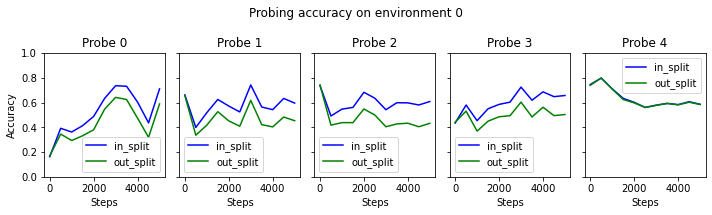

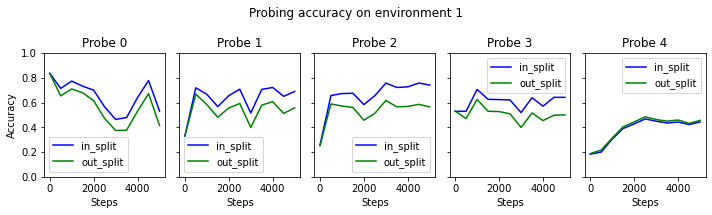

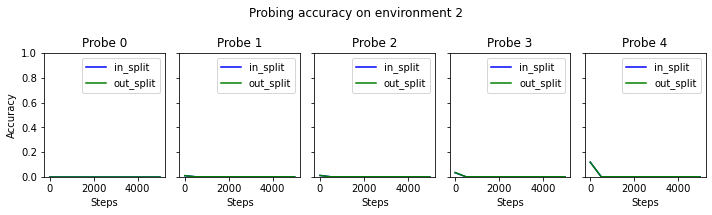

In [5]:
def make_plots_by_steps(results, envid=0, num_probes=5):
    steps = [res['step'] for res in results]
    fig, axes = plt.subplots(nrows=1, ncols=num_probes, figsize=(10,3), sharey=True)
    for pi in range(num_probes):
        in_results = []
        out_results = []
        for res in results:
            in_results.append(res[f"probe_{pi}_env_{envid}_insplit"])
            out_results.append(res[f"probe_{pi}_env_{envid}_outsplit"])
        axes[pi].plot(steps, in_results, "b", label="in_split")
        axes[pi].plot(steps, out_results, "g", label="out_split")
        axes[pi].set_xlabel("Steps")
        axes[pi].set_title(f"Probe {pi}")
        axes[pi].legend()
    
    axes[0].set_ylabel("Accuracy")
    axes[0].set_ylim([0,1])
    plt.suptitle(f"Probing accuracy on environment {envid}")
    plt.tight_layout()

def read_plot_results(checkpoint_dir, num_env=6, slurm_id=0):
    results = read_probing_result(checkpoint_dir, slurm_id)
    for envid in range(num_env):
        make_plots_by_steps(results, envid)
        
# read_plot_results("../checkpoints/ERM_RotatedMNIST_testenv2/")
# read_plot_results("../checkpoints/IRM_RotatedMNIST_testenv3/")
# read_plot_results("../checkpoints/MTL_RotatedMNIST_testenv1/")
# read_plot_results("../checkpoints/SagNet_ColoredMNIST_testenv1/", num_env=3)
read_plot_results("../checkpoints/DANN_ColoredMNIST_testenv2/", num_env=3)